# 18. 정규회귀 이외의 계층적 모형 

In [3]:
library(bayesrules)
library(tidyverse)
library(bayesplot)
library(rstanarm)
library(tidybayes)
library(broom.mixed)
library(janitor)

<br>

## 18.01. 계층적 로지스틱 모형

In [4]:
data(climbers_sub)

climbers <- climbers_sub %>% 
  select(expedition_id, member_id, success, year, season,
         age, expedition_role, oxygen_used)

In [10]:
climbers %>% nrow
climbers %>% head

[1] 2076

expedition_id,member_id,success,year,season,age,expedition_role,oxygen_used
<chr>,<fct>,<lgl>,<dbl>,<fct>,<dbl>,<fct>,<lgl>
AMAD81101,AMAD81101-03,TRUE,1981,Spring,28,Climber,FALSE
AMAD81101,AMAD81101-04,TRUE,1981,Spring,27,Exp Doctor,FALSE
AMAD81101,AMAD81101-02,TRUE,1981,Spring,35,Deputy Leader,FALSE
AMAD81101,AMAD81101-05,TRUE,1981,Spring,37,Climber,FALSE
AMAD81101,AMAD81101-06,TRUE,1981,Spring,43,Climber,FALSE
AMAD81101,AMAD81101-07,FALSE,1981,Spring,38,Climber,FALSE


In [7]:
climbers %>% 
  tabyl(success)

success,n,percent
<lgl>,<int>,<dbl>
FALSE,1269,0.6112717
TRUE,807,0.3887283


<br>

#### 200개의 그룹

In [9]:
climbers_per_expedition <- climbers %>% 
  group_by(expedition_id) %>% 
  summarize(count = n())

climbers_per_expedition %>% head

expedition_id,count
<chr>,<int>
AMAD03107,5
AMAD03327,6
AMAD05338,12
AMAD06110,5
AMAD06334,11
AMAD07101,8


#### 200개의 그룹별 평균 성공률

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


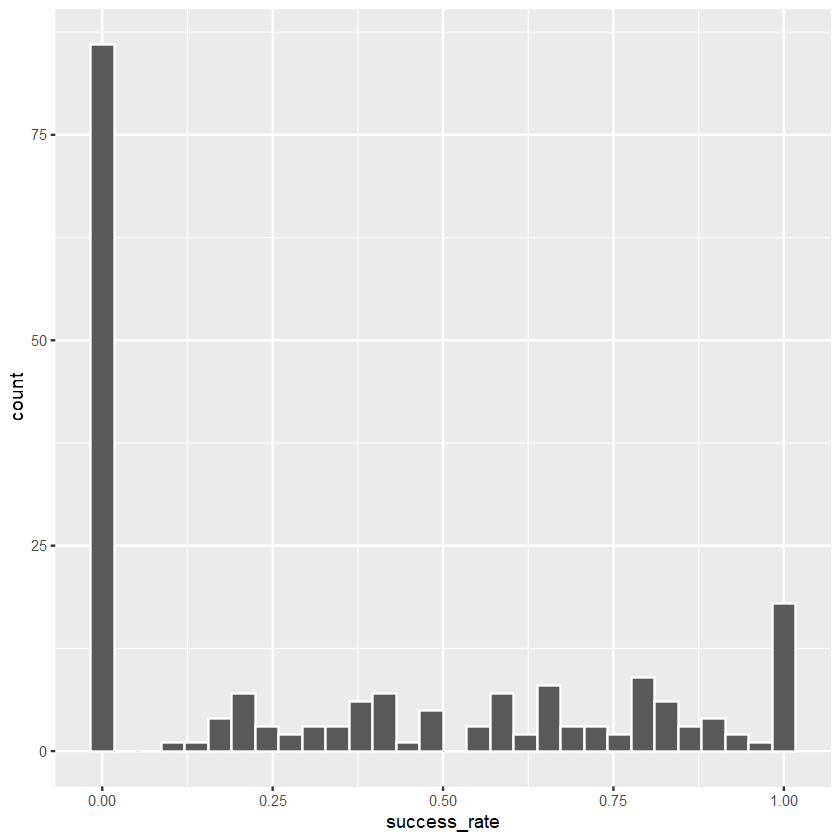

In [12]:
expedition_success <- climbers %>% 
  group_by(expedition_id) %>% 
  summarize(success_rate = mean(success))

ggplot(expedition_success, aes(x = success_rate)) + 
  geom_histogram(color = "white")

<br>

### 사전모형설정

In [ ]:
climb_model <- stan_glmer(
  success ~ age + oxygen_used + (1 | expedition_id), 
  data = climbers, family = binomial,
  prior_intercept = normal(0, 2.5, autoscale = TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_covariance = decov(reg = 1, conc = 1, shape = 1, scale = 1),
  chains = 4, iter = 5000*2, seed = 84735
)

In [15]:
prior_summarymmary(climb_model)

Priors for model 'climb_model' 
------
Intercept (after predictors centered)
 ~ normal(location = 0, scale = 2.5)

Coefficients
  Specified prior:
    ~ normal(location = [0,0], scale = [2.5,2.5])
  Adjusted prior:
    ~ normal(location = [0,0], scale = [0.24,5.51])

Covariance
 ~ decov(reg. = 1, conc. = 1, shape = 1, scale = 1)
------
See help('prior_summary.stanreg') for more details

$$\begin{equation}
\begin{array}{rll}
Y_{ij}|\beta_{0j},\beta_1, \beta_2 & \sim \text{Bern}(\pi_{ij}) & \text{(관측값에 대한 모형 (그룹내 변동성)}\\
\; \text{ with } & \log\left(\frac{\pi_{ij}}{1 - \pi_{ij}}\right) = \beta_{0j} + \beta_1 X_{ij1} + \beta_2 X_{ij2} & \\
\beta_{0j} | \beta_0, \sigma_0    & \stackrel{ind}{\sim} N(\beta_0, \sigma_0^2) & \text{(그룹별 절편에 대한 모형 (그룹간 변동성) } \\
\beta_{0c}  &  \sim N\left(0, 2.5^2 \right) & \text{(전역 회귀계수에 대한 모형)}\\
\beta_1  &  \sim N\left(0, 0.24^2 \right) & \\
\beta_2  &  \sim N\left(0, 5.51^2 \right) & \\
\sigma_0 & \sim \text{Exp}(1). & \\
\end{array}
\end{equation}$$

In [ ]:
# mcmc_trace(climb_model, size = 0.1)
# mcmc_dens_overlay(climb_model)
# mcmc_acf(climb_model)
# neff_ratio(climb_model)
# rhat(climb_model)

<br>

### 사후분포

In [16]:
tidy(climb_model, effects = "fixed", conf.int = TRUE, conf.level = 0.80)

term,estimate,std.error,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-1.41068582,0.475894479,-2.0345176,-0.8109510
age,-0.04765648,0.009260138,-0.0594632,-0.0359522
oxygen_usedTRUE,5.79565511,0.479126153,5.2051383,6.4310658


<br>

### 분류예측

- 4개의 새로운 관측값

In [22]:
new_expedition <- data.frame(
  age = c(20, 20, 60, 60), oxygen_used = c(FALSE, TRUE, FALSE, TRUE), 
  expedition_id = rep("new", 4))

new_expedition

age,oxygen_used,expedition_id
<dbl>,<lgl>,<chr>
20,FALSE,new
20,TRUE,new
60,FALSE,new
60,TRUE,new


- 4개의 새로운 관측값에 대한 예측

In [23]:
set.seed(84735)
binary_prediction <- posterior_predict(climb_model, newdata = new_expedition)

- 4개의 새로운 관측값별 성공 예측확률

In [20]:
colMeans(binary_prediction)

1       2       3       4 
0.27930 0.79675 0.14295 0.64820

<br>

### 모형평가

In [21]:
set.seed(84735)
classification_summary(data = climbers, model = climb_model, cutoff = 0.5)

$confusion_matrix
     y    0   1
 FALSE 1172  97
  TRUE   77 730

$accuracy_rates
                          
sensitivity      0.9045849
specificity      0.9235619
overall_accuracy 0.9161850

<br>

## 18.02.  계층적 포아송 & 음이항 회귀

In [28]:
data(airbnb)

nrow(airbnb)

[1] 1561

In [31]:
airbnb %>% head

,price,rating,reviews,room_type,accommodates,bedrooms,minimum_stay,neighborhood,district,walk_score,transit_score,bike_score
,<int>,<dbl>,<int>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>
1,85,5.0,6,Private room,2,1,1,Albany Park,Far North,87,62,68
2,35,5.0,8,Private room,1,1,1,Albany Park,Far North,87,62,68
3,175,4.5,7,Entire home/apt,4,2,2,Albany Park,Far North,87,62,68
4,75,5.0,52,Private room,2,1,1,Albany Park,Far North,87,62,68
5,160,5.0,3,Entire home/apt,6,2,1,Albany Park,Far North,87,62,68
6,60,5.0,5,Private room,1,1,1,Albany Park,Far North,87,62,68


#### 43개의 그룹

In [29]:
airbnb %>% 
  summarize(nlevels(neighborhood))

nlevels(neighborhood)
<int>
43


<br>

### 포아송 회귀 모형

In [ ]:
airbnb_model_1 <- stan_glmer(
  reviews ~ rating + room_type + (1 | neighborhood), 
  data = airbnb, family = poisson,
  prior_intercept = normal(3, 2.5, autoscale = TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_covariance = decov(reg = 1, conc = 1, shape = 1, scale = 1),
  chains = 4, iter = 5000*2, seed = 84735
)

In [ ]:
airbnb_model_1 <- stan_glmer(
  reviews ~ rating + room_type + (1 | neighborhood), 
  data = airbnb, family = poisson,
  prior_intercept = normal(3, 2.5, autoscale = TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_covariance = decov(reg = 1, conc = 1, shape = 1, scale = 1),
  chains = 4, iter = 5000*2, seed = 84735
)

In [34]:
prior_summary(airbnb_model_1)

Priors for model 'airbnb_model_1' 
------
Intercept (after predictors centered)
 ~ normal(location = 3, scale = 2.5)

Coefficients
  Specified prior:
    ~ normal(location = [0,0,0], scale = [2.5,2.5,2.5])
  Adjusted prior:
    ~ normal(location = [0,0,0], scale = [ 7.37, 5.04,14.19])

Covariance
 ~ decov(reg. = 1, conc. = 1, shape = 1, scale = 1)
------
See help('prior_summary.stanreg') for more details

$$\begin{equation}
\begin{array}{rl}
Y_{ij}|\beta_{0j},\beta_1, \beta_2, \beta_3 & \sim \text{Pois}(\lambda_{ij}) \;\; 
\text{ with }  \;\; \log(\lambda_{ij}) = \beta_{0j} + \beta_1 X_{ij1} + \beta_2 X_{ij2} + \beta_3 X_{ij3} \\
\beta_{0j} | \beta_0, \sigma_0    & \stackrel{ind}{\sim} N(\beta_0, \sigma_0^2)\\
\beta_{0c} & \sim N\left(3, 2.5^2 \right)\\
\beta_{1} & \sim N\left(0, 7.37^2 \right)\\
\beta_{2} & \sim N\left(0, 5.04^2 \right)\\
\beta_{3} & \sim N\left(0, 14.19^2 \right)\\
\sigma_0 & \sim \text{Exp}(1). \\
\end{array}
\end{equation}$$

#### 사후분포 검사결과, 데이터는 포아송 회귀모형을 적용하기에 과분산 되어있음을 확인

Warning message:
"Removed 8 rows containing non-finite values (`stat_density()`)."


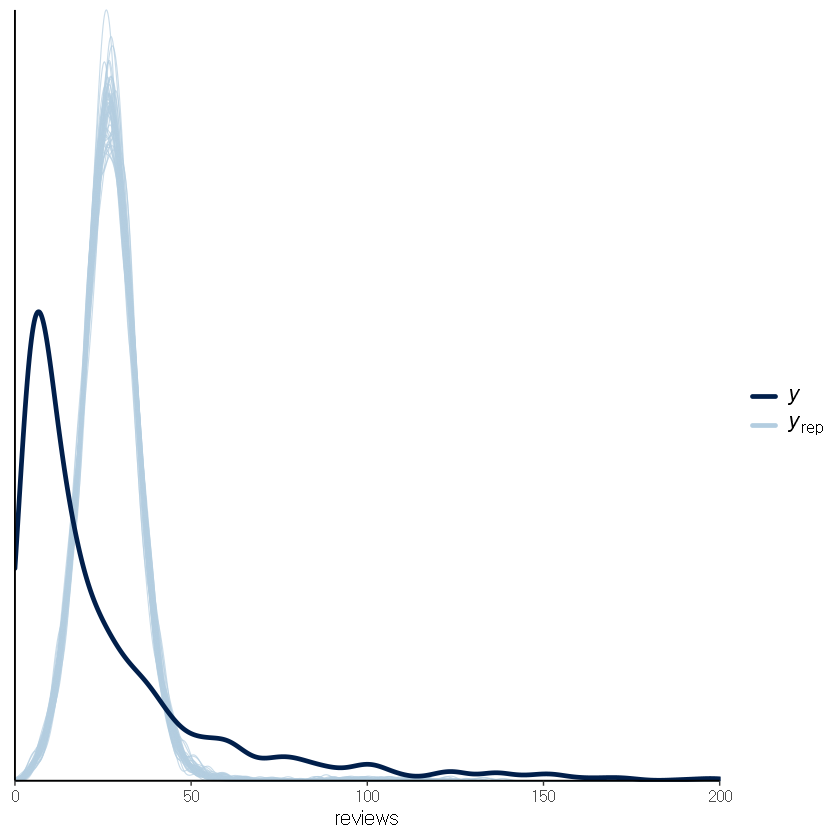

In [35]:
pp_check(airbnb_model_1) + 
  xlim(0, 200) + 
  xlab("reviews")

<br>

### 음이항 회귀 모형

In [ ]:
airbnb_model_2 <- stan_glmer(
  reviews ~ rating + room_type + (1 | neighborhood), 
  data = airbnb, family = neg_binomial_2,
  prior_intercept = normal(3, 2.5, autoscale = TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  prior_covariance = decov(reg = 1, conc = 1, shape = 1, scale = 1),
  chains = 4, iter = 5000*2, seed = 84735
)

In [38]:
prior_summary(airbnb_model_2)

Priors for model 'airbnb_model_2' 
------
Intercept (after predictors centered)
 ~ normal(location = 3, scale = 2.5)

Coefficients
  Specified prior:
    ~ normal(location = [0,0,0], scale = [2.5,2.5,2.5])
  Adjusted prior:
    ~ normal(location = [0,0,0], scale = [ 7.37, 5.04,14.19])

Auxiliary (reciprocal_dispersion)
 ~ exponential(rate = 1)

Covariance
 ~ decov(reg. = 1, conc. = 1, shape = 1, scale = 1)
------
See help('prior_summary.stanreg') for more details

$$\begin{equation}
\begin{array}{rl}
Y_{ij}|\beta_{0j},\beta_1, \beta_2, \beta_3, r & \sim \text{NegBin}(\mu_{ij}, r) \;\; \text{ with } \;\; \log(\mu_{ij}) = \beta_{0j} + \beta_1 X_{ij1} + \beta_2 X_{ij2} + \beta_3 X_{ij3} \\
\beta_{0j} | \beta_0, \sigma_0    & \stackrel{ind}{\sim} N(\beta_0, \sigma_0^2) \\
\beta_{0c} &  \sim N\left(3, 2.5^2 \right) \\
\beta_1 &  \sim N\left(0, 7.37^2 \right) \\
\beta_2 &  \sim N\left(0, 5.04^2 \right) \\
\beta_3 &  \sim N\left(0, 14.19^2 \right) \\
r & \sim \text{Exp}(1) \\
\sigma_0 & \sim \text{Exp}(1) \\
\end{array}
\end{equation}$$

#### 사후분포 검사결과, 음이항 회귀는 데이터의 특성을 잘 포착

Warning message:
"Removed 81 rows containing non-finite values (`stat_density()`)."
Warning message:
"Removed 8 rows containing non-finite values (`stat_density()`)."


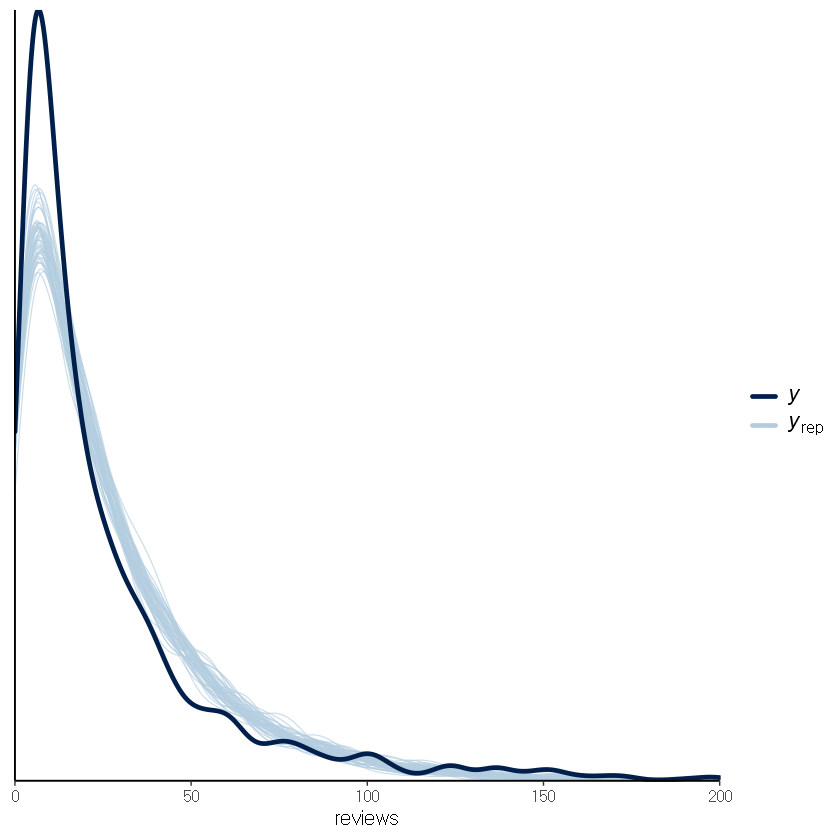

In [37]:
pp_check(airbnb_model_2) + 
  xlim(0, 200) + 
  xlab("reviews")

<br>

### 사후분포

In [39]:
tidy(airbnb_model_2, effects = "fixed", conf.int = TRUE, conf.level = 0.80)

term,estimate,std.error,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.99591676,0.39816649,1.48871101,2.5102228
rating,0.26455390,0.08314600,0.15667938,0.3703324
room_typePrivate room,0.06837476,0.05287219,0.00070166,0.1364916
room_typeShared room,-0.47020694,0.14980040,-0.65948546,-0.2755344


In [40]:
tidy(airbnb_model_2, effects = "ran_vals", 
     conf.int = TRUE, conf.level = 0.80) %>% 
  select(level, estimate, conf.low, conf.high) %>% 
  filter(level %in% c("Albany_Park", "East_Garfield_Park", "The_Loop"))

level,estimate,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>
Albany_Park,-0.233269505,-0.43185633,-0.05218517
East_Garfield_Park,0.201989079,0.03760021,0.39606763
The_Loop,0.008911772,-0.09951023,0.12588048


<br>

### 사후예측분포

- 새로운 관측값

In [41]:
data.frame(
rating = rep(5, 3), 
room_type = rep("Entire home/apt", 3), 
neighborhood = c("Albany Park", "East Garfield Park", "The Loop"))

rating,room_type,neighborhood
<dbl>,<chr>,<chr>
5,Entire home/apt,Albany Park
5,Entire home/apt,East Garfield Park
5,Entire home/apt,The Loop


- 예측

In [42]:
set.seed(84735)
predicted_reviews <- posterior_predict(
  airbnb_model_2, 
  newdata = data.frame(
    rating = rep(5, 3), 
    room_type = rep("Entire home/apt", 3), 
    neighborhood = c("Albany Park", "East Garfield Park", "The Loop")))

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"Removed 3 rows containing missing values (`geom_segment()`)."


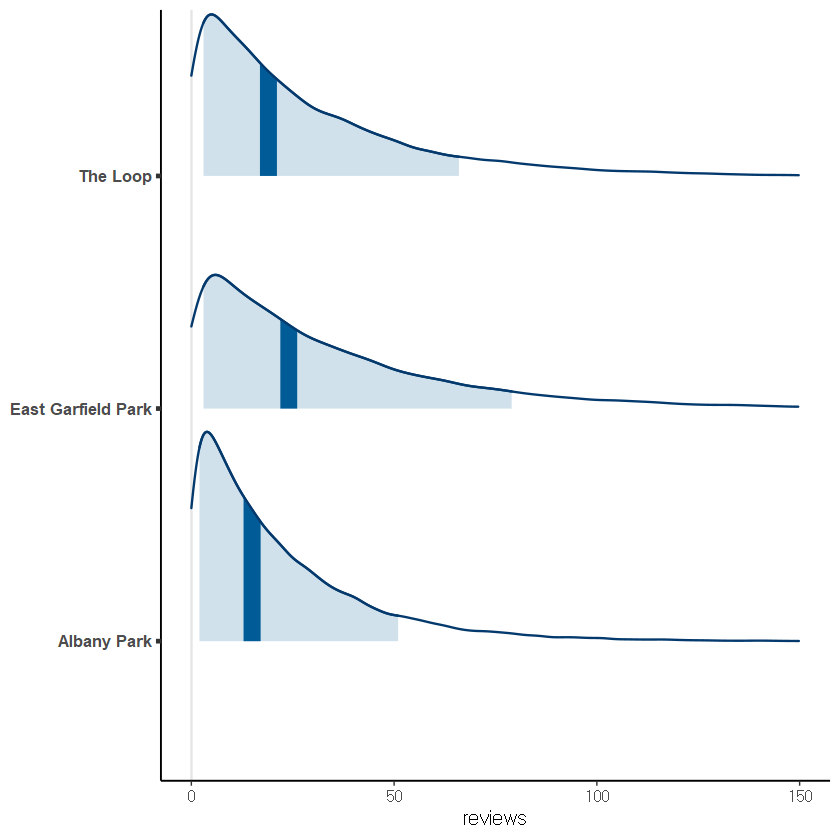

In [43]:
mcmc_areas(predicted_reviews, prob = 0.8) +
  ggplot2::scale_y_discrete(
    labels = c("Albany Park", "East Garfield Park", "The Loop")) + 
  xlim(0, 150) + 
  xlab("reviews")

<br>

### 모형 평가

In [44]:
set.seed(84735)
prediction_summary(model = airbnb_model_2, data = airbnb)

mae,mae_scaled,within_50,within_95
<dbl>,<dbl>,<dbl>,<dbl>
17.5983,0.6764801,0.5150545,0.9577194
